In [20]:
# Module Import

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [21]:
# 설계할 때 활용하는 장ㅂ ㅣ확인 
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('mps')
else:
    DEVICE = torch.device('cpu')
    print("cpu")
    
print('Using PyTorch version : ', torch.__version__, 'Deviece :', DEVICE )

mps
Using PyTorch version :  2.9.1 Deviece : mps


In [22]:
BATCH_SIZE = 32 # 한번 계산 할 때 사용할 데이터 수 
EPOCHS = 10 # 한번 전체를 도는 것이 epochs

In [23]:
# MNIST 데이터 다운로드 (Train Test Split)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR10", 
                               train = True, 
                               download = True, 
                               transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR10", 
                               train = False,  
                               transform = transforms.ToTensor()) # 이미지 파일을 tensor형태로 변경, 한 픽셀은 0 ~ 255 범위의 스칼라 값으로 구성, 이를 0 ~ 1 범위로 정규화

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = BATCH_SIZE, #Batch_Size 만큼 데이터를 묶어 1개의 Mini-Batch 구성하기 위해 loader 구성
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                           batch_size = BATCH_SIZE, 
                                           shuffle = False)

# loader을 구성하는 이유는 미니배치로 구성하기 위해 사용

In [24]:
# 데이터 확인하기 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break


# X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor -> 32개의 이미지가 하나의 배치/ 그 이미지는 28 * 28 픽셀의 형태 
# y_train: torch.Size([32]) type: torch.LongTensor -> 이미지 하나당 하나의 레이블을 차지하므로, 한 배치의 레이블 수는 32개가 된다. 

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


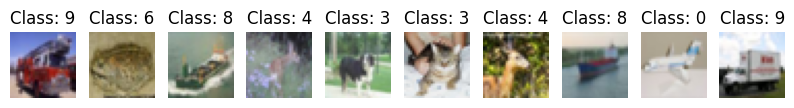

In [25]:
# 데이터 확인하기 2
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [26]:
class Net(nn.Module):                      
    def __init__(self):                     
        super(Net, self).__init__()         # nn.Module 내에 있는 메서드를 상속 받아 이용할 수 있게끔
        self.fc1 = nn.Linear(32 * 32 * 3, 512)    # 각 Fully Connected Layer 정의 (input, output)
        self.fc2 = nn.Linear(512, 256)      
        self.fc3 = nn.Linear(256, 10)  
             
    def forward(self, x) :                  # Forward propagation 정의
        x = x.view(-1, 32 * 32 * 3)         # 이미지 크기 * 채널 / 채널 : 색상               
        x = self.fc1(x)                     
        x = F.relu(x)                    
        x = self.fc2(x)                     
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)       # log_softmax를 이용해 확률값 계산 => Loss값에 대한 gradient를 원할하게 계산할 수 있기 때문
        return x

In [27]:
# optimizer, Objective Function 설정하기 (Back propagation)
model = Net().to(DEVICE)                    # DEVICE에 MLP 모델 할당
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 모델 사용
criterion = nn.CrossEntropyLoss()           # 벌점 이런거 주기 

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [28]:
# AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 
def train(model, train_loader, optimizer, log_interval): 
    model.train()                           # MLP을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):   # Mini-Batch 단위로 이미지 데이터가 묶여있음. => 순서대로 MLP 모형 학습
        image = image.to(DEVICE)            # 이미지 -> 장치에 할당
        label = label.to(DEVICE)            # 라벨 -> 장치에 할당
        optimizer.zero_grad()               # 지난번 할당한 것 지우는 것 
        
        output = model(image)               # 이미지 데이터를 인풋으로 모델을 돌려 아웃풋 계산
        loss = criterion(output, label)     # Loss funtion 작동
        loss.backward()                     # (auto_grad)계산된 gradient 값을 각 파라미터에 할당
        optimizer.step()                    # 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{} / {}({:.0f}%)]\tTrain Loss: {:6f}".format(Epoch, batch_idx * len(image), 
                                                                                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                                  loss.item()))
            
            


In [32]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 
def evaluate(model, test_loader):
    model.eval()                            # 모델을 평가상태로 지정
    test_loss = 0                           # Loss 계산하기 위한 초기 설정
    correct = 0
    
    with torch.no_grad():                   # gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:    # Mini-batch 내에 있는 이미지 데이터와 레이블 데이터에 접근
            image = image.to(DEVICE)        
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item()    # 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 계산된 걸 test_loss
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()            
    test_loss /= len(test_loader.dataset)   # test_loss를 mini-batch 개수만큼 나눠 평균 Loss값으로 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [33]:
# MLP 학습을 실행하면서 Train, Test  set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(Epoch, test_loss, test_accuracy))

    

Train Epoch : 1 [0 / 50000(0%)]	Train Loss: 1.887059
Train Epoch : 1 [6400 / 50000(13%)]	Train Loss: 1.507492
Train Epoch : 1 [12800 / 50000(26%)]	Train Loss: 1.341954
Train Epoch : 1 [19200 / 50000(38%)]	Train Loss: 1.622151
Train Epoch : 1 [25600 / 50000(51%)]	Train Loss: 1.727430
Train Epoch : 1 [32000 / 50000(64%)]	Train Loss: 1.575823
Train Epoch : 1 [38400 / 50000(77%)]	Train Loss: 1.519756
Train Epoch : 1 [44800 / 50000(90%)]	Train Loss: 1.617512

[EPOCH: 1], 	Test Loss: 0.0486, 	Test Accuracy: 44.28 % 

Train Epoch : 2 [0 / 50000(0%)]	Train Loss: 1.285110
Train Epoch : 2 [6400 / 50000(13%)]	Train Loss: 1.589547
Train Epoch : 2 [12800 / 50000(26%)]	Train Loss: 1.444128
Train Epoch : 2 [19200 / 50000(38%)]	Train Loss: 1.646378
Train Epoch : 2 [25600 / 50000(51%)]	Train Loss: 1.664613
Train Epoch : 2 [32000 / 50000(64%)]	Train Loss: 1.648216
Train Epoch : 2 [38400 / 50000(77%)]	Train Loss: 1.496912
Train Epoch : 2 [44800 / 50000(90%)]	Train Loss: 1.542132

[EPOCH: 2], 	Test Loss: 